# Transfer Learning tutorial

PyTorch Tutorialの[Transfer Learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)を参考にして実施します。


原文では虫を分類していますが、せっかくなのでカワイイデータを使いたかったので下記データセットを使います。

http://www.robots.ox.ac.uk/~vgg/data/pets/

試験的に、[LiveLossPlot](https://github.com/stared/livelossplot)を使います

In [23]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

from livelossplot import PlotLosses  # 試験的に使用します。

/home/takoroy/datascience/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Download Dataset
データをダウンロードします。

In [2]:
download_flag = not os.path.exists("./pet_dataset/images.tar.gz")

In [3]:
if download_flag:
    import tarfile
    import urllib
    os.makedirs('./pet_dataset/', exist_ok=True)
    url = 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'
    urllib.request.urlretrieve(url, './pet_dataset/images.tar.gz')

In [4]:
!tar -xzf ./pet_dataset/images.tar.gz -C ./pet_dataset/

## Train/Valid Split
画像ののパスとクラスを取得し、教師データと評価データのディレクトリに整理します。

In [5]:
X_file = []
y = []

data_dir = "./pet_dataset/images/"

for fname in os.listdir(data_dir):
    if not fname.endswith('.jpg'):
        continue
    y.append('_'.join(fname.split('_')[:-1]).lower())
    X_file.append(os.path.join(data_dir,fname))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_file, y, test_size=0.2, stratify=y)

In [7]:
# ディレクトリを作って教師データと評価データは別々に保存する

import shutil
for label in np.unique(y):
    os.makedirs(os.path.join("./pet_dataset/train", label), exist_ok=True)
    os.makedirs(os.path.join("./pet_dataset/val", label), exist_ok=True)
for img_path, label in zip(X_train, y_train):
    shutil.copy(img_path, os.path.join("./pet_dataset/train", label, img_path.split('/')[-1]))
for img_path, label in zip(X_test, y_test):
    shutil.copy(img_path, os.path.join("./pet_dataset/val", label, img_path.split('/')[-1]))

## Data Loader
データローダーの作成

In [8]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

In [9]:
# データ拡張
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEAN, IMG_STD)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEAN, IMG_STD)
    ]),
}

root_dir = './pet_dataset/'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(root_dir, x), data_transforms[x]) 
    for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

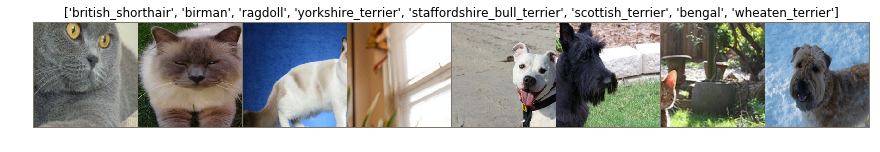

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMG_MEAN)
    std = np.array(IMG_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # 最小値0, 最大値1でクリップ
    plt.figure(figsize=(15,5))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # live loss plot
    liveloss = PlotLosses() 

    for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

        # Each epoch has a training and validation phase
        losses = {}
        accuracies = {}
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))
            losses[phase] = epoch_loss
            accuracies[phase] = epoch_acc

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        liveloss.update({
            'loss': losses['train'],
            'val_loss': losses['val'],
            'accuracy': accuracies['train'],
            'val_accuracy': accuracies['val']
        })
        liveloss.draw()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [13]:
def visualize_validation(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            imshow(inputs.cpu().data[j], 'answer: {}\npredicted: {}'.format(
                class_names[labels[j]],class_names[preds[j]]))

            if images_so_far == num_images:
                return

## Confusion Matrix

混同行列を表示する

In [14]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels):
    import seaborn as sns
    import pandas as pd
    sns.set()
    
    df = pd.DataFrame(cm)
    df.index = labels
    df.columns = labels

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(df, annot=True, fmt="d", linewidths=.5, ax=ax)

def validation_confusion_matrix(model):
    images_so_far = 0
    fig = plt.figure()

    all_labels = np.array([])
    all_preds = np.array([])
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        all_labels = np.append(all_labels, labels.cpu().data.numpy())
        all_preds = np.append(all_preds, preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names)

## Finetuning the convnet

すでに学習済みの重みはあまり動かさずに、全結合層のみ追加し、「全体を」チューニングする

In [28]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

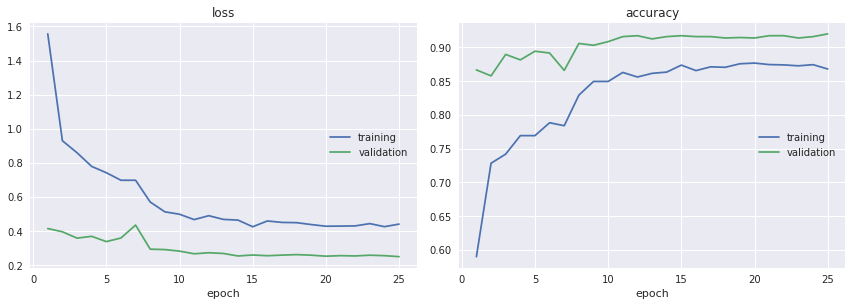

Training complete in 7m 59s
Best val Acc: 0.920162


In [29]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

<Figure size 432x288 with 0 Axes>

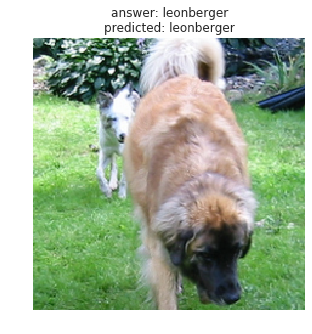

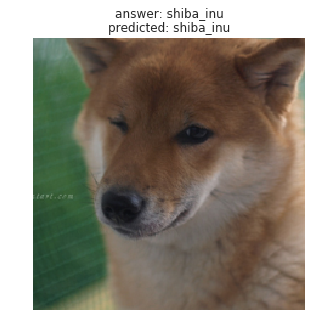

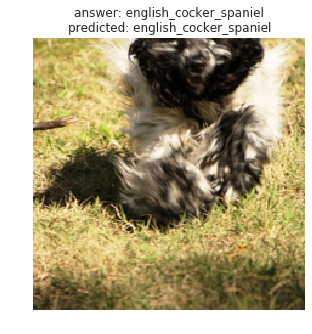

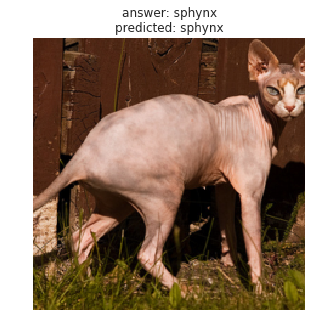

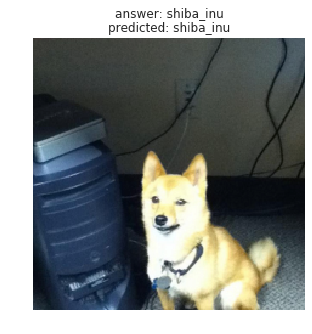

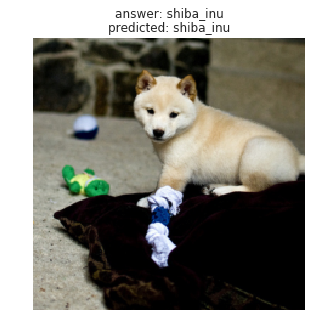

In [30]:
visualize_validation(model_ft)

<Figure size 432x288 with 0 Axes>

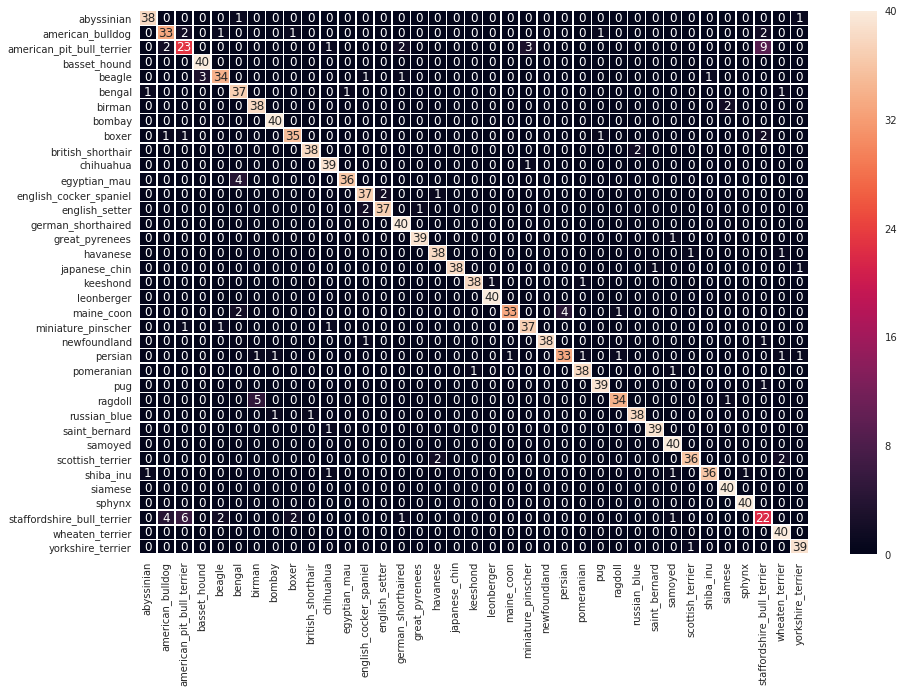

In [31]:
validation_confusion_matrix(model_ft) 

# ConvNet as fixed feature extractor

全結合層のみを再学習するケース

In [32]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False  # Don't Train

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

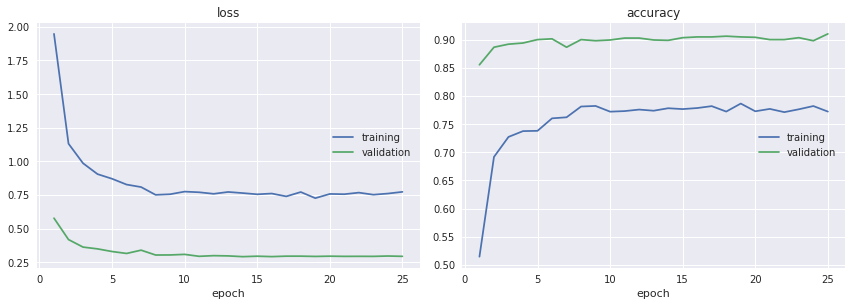

Training complete in 6m 56s
Best val Acc: 0.910014


In [33]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

<Figure size 432x288 with 0 Axes>

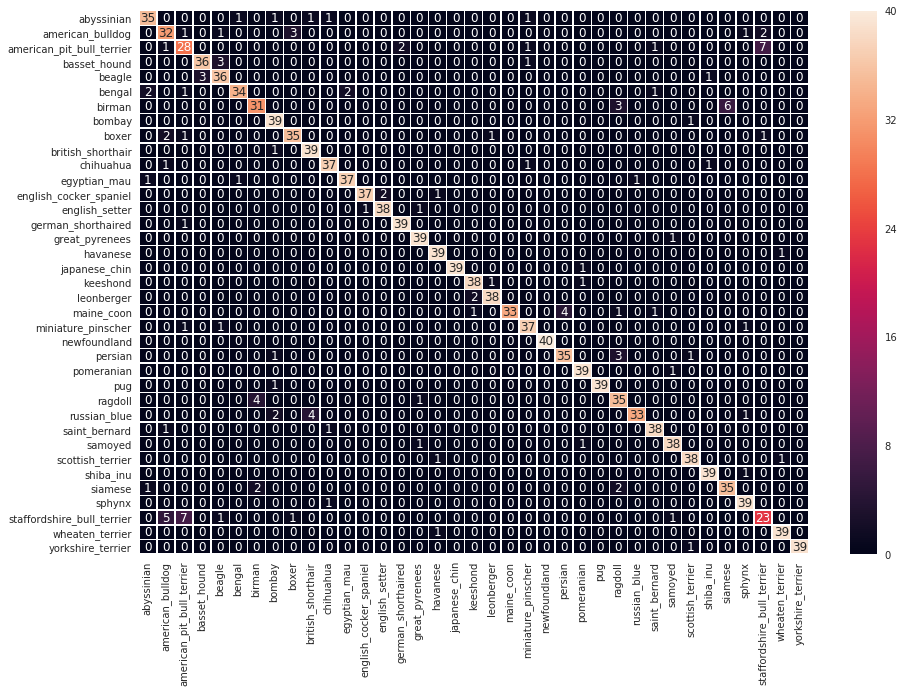

In [34]:
validation_confusion_matrix(model_conv)